In [5]:
import subprocess
import pandas as pd
import glob
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

## run gat

In [ ]:
all_te_classes = ['DNA','LINE','SINE','LTR']
all_te_files = [f'{_dir}/mm10.repeatmasker.repClass-{te_class}.bed' for te_class in all_te_classes]

In [2]:
all_te_files = glob.glob(f"te_subfamily_bed/*")
len(all_te_files)

1072

In [3]:
_type = 'Hyper'
out_dir = f'{_type}_te_subfamily_result'

In [4]:
import pathlib
pathlib.Path(f'{out_dir}').mkdir(exist_ok = True)

with open(f'{_type}_enrich_rep_subclass.sh', 'w') as f:
    count = 0  # Initialize counter
    for file in all_te_files:
        _tmp_class = pathlib.Path(file).name.split('.')[0]
        command = f"gat-run.py --segments {_type}.bed \
--annotations {file} \
--workspace mm10.chrom.bed \
--ignore-segment-tracks \
--num-samples=10001 > {out_dir}/gat-{_tmp_class}-rep.rlt     &"
        f.write(command + '\n')
        count += 1  # Increment counter

        # Check if count has reached 30
        if count == 40:
            f.write('wait\n')  # Write wait command
            count = 0  # Reset counter

    # Ensure the final wait if the last batch has less than 30 files
    if count != 0:
        f.write('wait\n')


## plot results

In [6]:
all_results_files = glob.glob(f'Hypo_te_subfamily_result/*.rlt')

results = []
for file in all_results_files:
    _class = pathlib.Path(file).name.split('-rep')[0].split('gat-')[-1]
    try:
        tmpdf = pd.read_csv(file, comment = '#', sep = '\t')
    except Exception as e:
        continue
    tmpdf['class'] = _class
    results.append(tmpdf)
results = pd.concat(results)

In [14]:
toplot = results[['observed','expected', 'pvalue','qvalue','class']].copy() # 'annotation',
toplot['fold'] = toplot['observed'] / toplot['expected']
toplot = toplot[(toplot['qvalue'] < 1e-2) & (toplot['fold'] > 1)].sort_values('fold', ascending = False)
toplot = toplot.groupby('class').mean()
toplot = toplot.sort_values('expected', ascending = False)
toplot.head()

,observed,expected,pvalue,qvalue,fold
class,,,,,
MIRc,1783.0,855.52865,0.0045,0.004799,2.084200
L2b,1627.0,595.89130,0.0030,0.005999,2.730364
IAPLTR2_Mm,1428.0,202.89250,0.0009,0.001800,7.038210
MuRRS-int,2136.5,166.81660,0.0001,0.000100,12.726505
L1MA5A,1257.0,140.09800,0.0011,0.002200,8.972291


In [15]:
te_order = toplot.sort_values('expected', ascending = False)['expected'].index

In [16]:
# all_te_files = glob.glob(f"te_subfamily_bed/*")
# all_te_files[:2]

# subfamily_info = {}
# for file_path in all_te_files:
#     tmpdf = pd.read_csv(file_path, sep = '\t', header = None)
#     tmpdf = tmpdf[tmpdf[4].isin(toplot.index)]
#     tmpdf['unique_id'] = tmpdf[5] + '.' + tmpdf[4] #'.' + tmpdf[6] + 
#     if tmpdf.shape[0] != 0:
#         new_id = tmpdf['unique_id'].unique()[0]
#         subfamily_info[new_id.split('.')[-1]] = new_id

In [17]:
#toplot.index = toplot.index.map(subfamily_info)
stat_text_1 = toplot.apply(lambda x:f"FC={x['fold']:.1f}\np<{x['qvalue']:.0e}", axis=1).tolist()

In [18]:
use_toplot = toplot.drop(columns = ['fold','qvalue','pvalue'])
use_toplot['TE_Info'] = use_toplot.index

use_toplot = use_toplot.melt(id_vars = 'TE_Info')
use_toplot.columns = ['TE_Info', 'Group','Count']
use_toplot.head()

,TE_Info,Group,Count
0,MIRc,observed,1783.0
1,L2b,observed,1627.0
2,IAPLTR2_Mm,observed,1428.0
3,MuRRS-int,observed,2136.5
4,L1MA5A,observed,1257.0


In [19]:
palette = {'observed':'#6495ED','expected':'lightgrey'}

Text(0.5, 0.98, 'TE Enrichment in Aging-Hypo Hotspot')

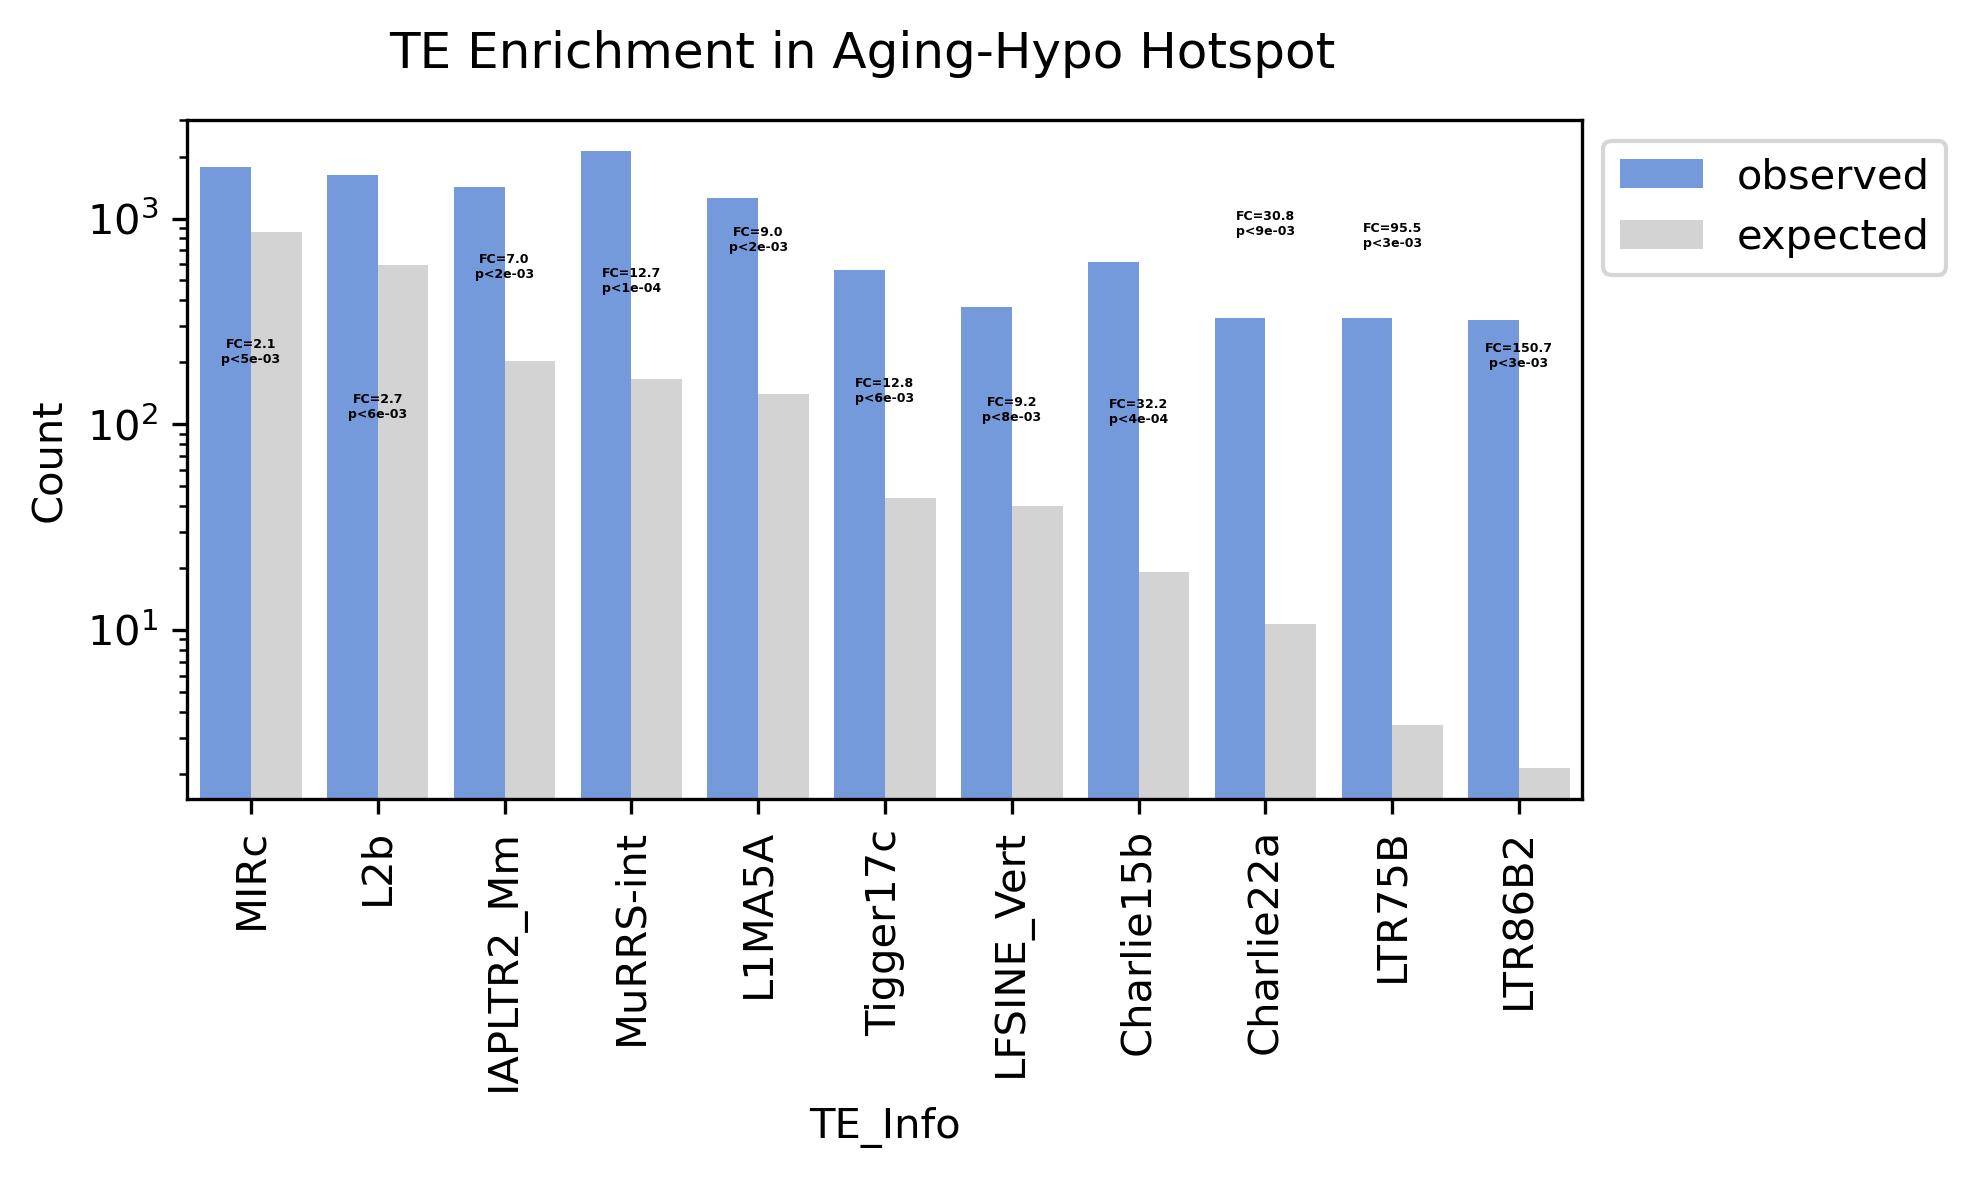

In [24]:
x='TE_Info'
y='Count'
hue='Group'
    
fig, ax = plt.subplots(figsize = (6,3), dpi = 300)
ax = sns.barplot(data =use_toplot, 
                 order = te_order,
                 x=x, 
                 y=y, 
                 hue=hue, 
                 palette = palette)

for x,(txt, y) in enumerate(zip(stat_text_1, use_toplot.groupby('TE_Info').mean()['Count']/1.2)):
    plt.text(x, y, txt, fontsize=3,va = 'top',ha='center',weight='bold')

plt.xticks(rotation=90)
ax.set_yscale('log')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('TE Enrichment in Aging-Hypo Hotspot')
#plt.savefig(f"hotspot.enrich.pdf", bbox_inches='tight')
#plt.show()

In [25]:
te_order

Index(['MIRc', 'L2b', 'IAPLTR2_Mm', 'MuRRS-int', 'L1MA5A', 'Tigger17c',
       'LFSINE_Vert', 'Charlie15b', 'Charlie22a', 'LTR75B', 'LTR86B2'],
      dtype='object', name='class')